In [ ]:
# Ignore InterpolationMode warnings from torchmeta
import warnings

warnings.filterwarnings("ignore")

In [ ]:
pip install torchmeta

In [ ]:
import math
import os

import easydict
import matplotlib.pyplot as plt
import numpy as np

# torch <= 1.9.1
import torch
import torch.nn as nn
import torch.nn.functional as F

# In Colab, install torchmeta using 'pip install torchmeta'
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from tqdm import tqdm

In [ ]:
def get_dataloader(args):
    train_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_train=True,
        download=args.download,
    )
    train_dataloader = BatchMetaDataLoader(
        train_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    test_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_test=True,
        download=args.download,
    )
    test_dataloader = BatchMetaDataLoader(
        test_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    val_dataset = omniglot(
        args.folder,
        shots=args.num_shots,
        # test_shots=1, # default = shots
        ways=args.num_ways,
        shuffle=True,
        meta_val=True,
        download=args.download,
    )
    val_dataloader = BatchMetaDataLoader(
        val_dataset, batch_size=args.task_batch_size, shuffle=True, num_workers=1
    )

    return train_dataloader, test_dataloader, val_dataloader

In [ ]:
def save_model(args, model, title):
    if not os.path.isdir(args.output_folder):
        os.mkdir(args.output_folder)
    filename = os.path.join(args.output_folder, title)
    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("model saved in", filename)


def load_model(args, model, title):
    print("Load model")
    filename = os.path.join(args.output_folder, title)
    model.load_state_dict(torch.load(filename))

In [ ]:
def print_graph(train_accuracies, val_accuracies, train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_accuracies, label="train_acc")
    axs[0].plot(val_accuracies, label="test_acc")
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_losses, label="train_loss")
    axs[1].plot(val_losses, label="test_loss")
    axs[1].set_title("Loss")
    axs[1].legend()

    fig.show()

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, x_dim=1, hid_dim=64, z_dim=64):
        super(EmbeddingNet, self).__init__()
        self.encoder = nn.Sequential(
            EmbeddingNet._conv_block(x_dim, hid_dim),
            EmbeddingNet._conv_block(hid_dim, hid_dim),
            EmbeddingNet._conv_block(hid_dim, hid_dim),
            EmbeddingNet._conv_block(hid_dim, z_dim),
        )

    @staticmethod
    def _conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        x = self.encoder(x)
        out = x.view(x.size(0), -1)

        return out

In [ ]:
class CasualConv1d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True
    ):
        super(CasualConv1d, self).__init__()
        self.dilation = dilation
        padding = dilation * (kernel_size - 1)
        self.conv1d = nn.Conv1d(
            in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias
        )

    def forward(self, input_):
        out = self.conv1d(input_)
        return out[:, :, : -self.dilation]

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, dilation, filters, kernel_size=2):
        super(DenseBlock, self).__init__()
        self.causal_conv1 = CasualConv1d(in_channels, filters, kernel_size, dilation=dilation)
        self.causal_conv2 = CasualConv1d(in_channels, filters, kernel_size, dilation=dilation)

    def forward(self, input_):
        xf = self.causal_conv1(input_)
        xg = self.causal_conv2(input_)
        activations = torch.tanh(xf) * torch.sigmoid(xg)

        return torch.cat((input_, activations), dim=1)

In [ ]:
class TCBlock(nn.Module):
    def __init__(self, in_channels, seq_length, filters):
        super(TCBlock, self).__init__()
        self.dense_blocks = nn.ModuleList(
            [
                DenseBlock(in_channels + i * filters, 2 ** (i + 1), filters)
                for i in range(int(math.ceil(math.log(seq_length, 2))))
            ]
        )

    def forward(self, input_):
        input_ = torch.transpose(input_, 1, 2)
        for block in self.dense_blocks:
            input_ = block(input_)

        return torch.transpose(input_, 1, 2)

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, key_size, value_size):
        super(AttentionBlock, self).__init__()
        self.query_layer = nn.Linear(in_channels, key_size)
        self.keys_layer = nn.Linear(in_channels, key_size)
        self.values_layer = nn.Linear(in_channels, value_size)
        self.sqrt_key_size = math.sqrt(key_size)
        self.key_size = key_size

    @staticmethod
    def CausallyMaskedSoftmax(logits, key_size):
        seq_len = logits.shape[1]
        mask = np.array([[i > j for i in range(seq_len)] for j in range(seq_len)])
        mask = torch.BoolTensor(mask).to(logits.get_device())
        logits = logits.data.masked_fill(mask, -float("inf"))

        return F.softmax(logits / math.sqrt(key_size), dim=1)

    def forward(self, input_):
        keys = self.keys_layer(input_)
        query = self.query_layer(input_)
        logits = torch.bmm(query, torch.transpose(keys, 1, 2))
        probs = AttentionBlock.CausallyMaskedSoftmax(logits, self.key_size)

        values = self.values_layer(input_)
        read = torch.bmm(probs, values)

        return torch.cat((input_, read), dim=2)

In [ ]:
class SNAIL(nn.Module):
    def __init__(self, num_ways, num_shots):
        super(SNAIL, self).__init__()

        self.num_ways, self.num_shots = num_ways, num_shots

        self.encoder = EmbeddingNet()
        num_channels = 64 + num_ways
        num_filters = int(math.ceil(math.log(num_ways * num_shots + 1, 2)))
        self.attention1 = AttentionBlock(num_channels, 64, 32)
        num_channels += 32
        self.tc1 = TCBlock(num_channels, num_ways * num_shots + 1, 128)
        num_channels += num_filters * 128
        self.attention2 = AttentionBlock(num_channels, 256, 128)
        num_channels += 128
        self.tc2 = TCBlock(num_channels, num_ways * num_shots + 1, 128)
        num_channels += num_filters * 128
        self.attention3 = AttentionBlock(num_channels, 512, 256)
        num_channels += 256
        self.fc = nn.Linear(num_channels, num_ways)

    def forward(self, x_seq, y_seq):
        x_emb = self.encoder(x_seq)
        batch_size = int(y_seq.size()[0] / (self.num_ways * self.num_shots + 1))

        last_idxs = [(i + 1) * (self.num_ways * self.num_shots + 1) - 1 for i in range(batch_size)]
        y_seq[last_idxs] = torch.Tensor(np.zeros((batch_size, y_seq.size()[1]))).to(y_seq.get_device())

        x_cat = torch.cat((x_emb, y_seq), 1)
        x_view = x_cat.view((batch_size, self.num_ways * self.num_shots + 1, -1))
        x_att1 = self.attention1(x_view)
        x_tc1 = self.tc1(x_att1)
        x_att2 = self.attention2(x_tc1)
        x_tc2 = self.tc2(x_att2)
        x_att3 = self.attention3(x_tc2)
        x_out = self.fc(x_att3)
        return x_out

In [ ]:
def generate_sequence(task_batch, num_ways, num_shots):
    support_xs, support_ys = task_batch["train"]
    query_xs, query_ys = task_batch["test"]

    chosen_indices = torch.randint(query_xs.shape[1], size=(query_xs.shape[0],))
    chosen_query_xs = query_xs[torch.arange(query_xs.shape[0]), chosen_indices, :, :, :].unsqueeze(1)
    chosen_query_ys = query_ys[torch.arange(query_ys.shape[0]), chosen_indices].unsqueeze(1)

    x_seq = torch.cat((support_xs, chosen_query_xs), dim=1).reshape((-1, *support_xs.shape[2:]))
    y_seq = torch.cat((support_ys, chosen_query_ys), dim=1).reshape((-1, *support_ys.shape[2:]))

    y_seq_onehot = F.one_hot(y_seq).float()

    query_y = y_seq[:: (num_ways * num_shots + 1)].long()

    return x_seq, y_seq_onehot, query_y

In [ ]:
def train_SNAIL(args, task_batch, model, criterion, optimizer):
    model.train()

    x_seq, y_seq, query_y = generate_sequence(task_batch, args.num_ways, args.num_shots)
    x_seq = x_seq.to(device=args.device)
    y_seq = y_seq.to(device=args.device)
    query_y = query_y.to(device=args.device)

    query_prob = model(x_seq, y_seq)[:, -1, :]
    loss = criterion(query_prob, query_y)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        _, query_preds = query_prob.max(1)
        accuracy = torch.eq(query_preds, query_y).float().mean()

    return accuracy.item(), loss.item()

In [ ]:
def test_SNAIL(args, task_batch, model, criterion, optimizer):
    model.eval()

    x_seq, y_seq, query_y = generate_sequence(task_batch, args.num_ways, args.num_shots)
    x_seq = x_seq.to(device=args.device)
    y_seq = y_seq.to(device=args.device)
    query_y = query_y.to(device=args.device)

    query_prob = model(x_seq, y_seq)[:, -1, :]
    loss = criterion(query_prob, query_y)

    with torch.no_grad():
        _, query_preds = query_prob.max(1)
        accuracy = torch.eq(query_preds, query_y).float().mean()

    return accuracy.item(), loss.item()

In [ ]:
args = easydict.EasyDict(
    {
        "folder": "dataset",
        "download": True,
        "num_shots": 1,
        "num_ways": 5,
        "output_folder": "model",
        "task_batch_size": 32,  # 필수
        "num_task_batch_train": 600,  # 필수
        "num_task_batch_test": 200,  # 필수
        "device": "cuda",  # 필수
    }
)

train_dataloader, test_dataloader, val_dataloader = get_dataloader(args)
model = SNAIL(args.num_ways, args.num_shots).to(device=args.device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

100%|██████████| 600/600 [03:20<00:00,  2.99it/s, train_accuracy=1.0000, train_loss=0.0239, val_accuracy=1.0000, val_loss=0.0234]


model saved in model/SNAIL.th


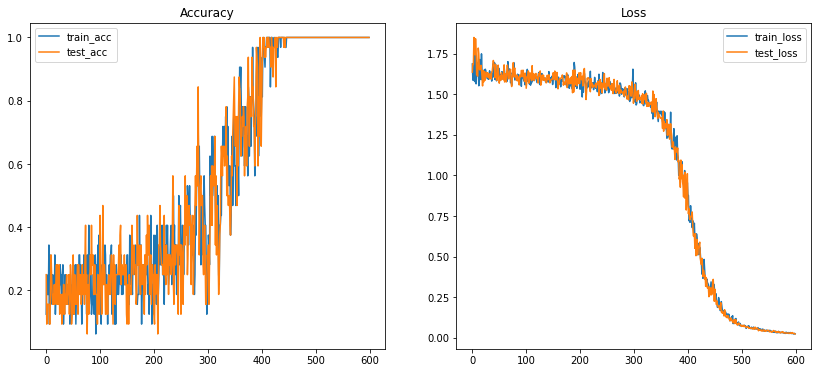

In [ ]:
# Training loop
with tqdm(zip(train_dataloader, val_dataloader), total=args.num_task_batch_train) as pbar:
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_train:
            break

        train_accuracy, train_loss = train_SNAIL(args, train_batch, model, criterion, optimizer)
        val_accuracy, val_loss = test_SNAIL(args, val_batch, model, criterion, optimizer)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(
            train_accuracy="{0:.4f}".format(train_accuracy),
            val_accuracy="{0:.4f}".format(val_accuracy),
            train_loss="{0:.4f}".format(train_loss),
            val_loss="{0:.4f}".format(val_loss),
        )

    # save model
    save_model(args, model, "SNAIL.th")
    print_graph(train_accuracies, val_accuracies, train_losses, val_losses)

In [ ]:
# load model
load_model(args, model, "SNAIL.th")

# Testing loop
with tqdm(test_dataloader, total=args.num_task_batch_test) as pbar:
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0

    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_test:
            break

        test_accuracy, test_loss = test_SNAIL(args, test_batch, model, criterion, optimizer)

        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss
        pbar.set_postfix(
            test_accuracy="{0:.4f}".format(sum_test_accuracies / (task_batch_idx + 1)),
            test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1)),
        )

Load model


100%|██████████| 200/200 [00:47<00:00,  4.23it/s, test_accuracy=1.0000, test_loss=0.0258]
